In [37]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader

train_df = pd.read_csv('/Users/apple/Desktop/Group-12-LLM/data/processed/train_data.csv') 
test_df = pd.read_csv('/Users/apple/Desktop/Group-12-LLM/data/processed/test_data.csv') 

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class SarcasmDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens  
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        tokens = self.tokens[idx]
        label = self.labels[idx]

        inputs = tokenizer(
            tokens,                
            padding='max_length',  
            truncation=True,       
            max_length=128,        
            return_tensors="pt"   
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),  
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_df['features'] = train_df.drop(columns=['label']).astype(str).agg(' '.join, axis=1)
test_df['features'] = test_df.drop(columns=['label']).astype(str).agg(' '.join, axis=1)

train = SarcasmDataset(tokens=train_df['features'], labels=train_df['label'])
test = SarcasmDataset(tokens=test_df['features'], labels=test_df['label'])

print(train.tokens)
print(test.tokens)

0         oh yeah those bike lanes have sure made the wh...
1         dun dun dun the plot thickens puppet_account p...
2         crying like a little bitch again huh JMurray11...
3         nonsense its all about kunfidunceright guyz Go...
4         what a demonstration of deep game mechanics un...
                                ...                        
705336    is not it worth it with the prospect of making...
705337    ysera TheWaxMann hearthstone 0.053043750652605...
705338    holy fuck Dexelele GlobalOffensive 0.052939333...
705339    they probably just checked and saw that you we...
705340    that will teach her to try and help orphans Be...
Name: features, Length: 705341, dtype: object
0         this is how you teabag your girlfriend amirigh...
1         and now she will sue the fdny for putting her ...
2         looks the exact same as my ref cooler for my  ...
3         like every other trade agreement in history my...
4         i do not understand what you mean VanGoghing

In [38]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2024-10-24 00:45:28,011 - INFO - Logging system initialized.
2024-10-24 00:45:28,012 - INFO - Starting evaluation...
2024-10-24 00:45:28,284 - INFO - Batch 1/9447 processed.
2024-10-24 00:45:28,496 - INFO - Batch 2/9447 processed.
2024-10-24 00:45:28,707 - INFO - Batch 3/9447 processed.
2024-10-24 00:45:28,917 - INFO - Batch 4/9447 processed.
2024-10-24 00:45:29,128 - INFO - Batch 5/9447 processed.
2024-10-24 00:45:29,343 - INFO - Batch 6/9447 processed.
2024-10-24 00:45:29,555 - INFO - Batch 7/9447 processed.
2024-10-24 00:45:29,758 - INFO - Batch 8/9447 processed.
2024-10-24 00:45:29,978 - INFO - Batch 9/9447 processed.
2024-10-24 00:45:30,180 - INFO - Batch 10/9447 processed.
2024-10-24 00:45:30,387 - INFO - Batch 11/9447 processed.
2024-10-24 00:45:30,592 - INFO - Batch 12/9447 processed.
2024-10-24 00:45:30,792 - INFO - Batch 13/9447 processed.
2024-10-24 00:45:30,999 - INFO - Batch 14/9447 processed.
2024-10-24 00:45:31,203 - INFO - Batch 15/9447 processed.
2024-10-24 00:45:31,40

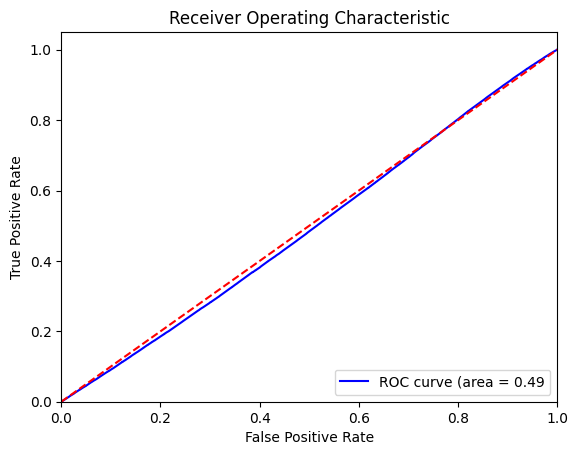

2024-10-24 01:18:01,183 - INFO - Evaluation completed.
2024-10-24 01:18:01,184 - INFO - Accuracy: 0.5008, F1 Score: 0.6674, ROC AUC: 0.4919


Accuracy: 0.5008
F1 Score: 0.6674
AUC-ROC: 0.4919


In [28]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import logging
import time

def evaluate_model(model, test_dataset):
    logging.basicConfig(filename='logs', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)

    device = torch.device("mps") 
    model.to(device)

    logger.info("Logging system initialized.")

    model.eval()
    predictions = []
    true_labels = []
    all_logits = []
    all_probabilities = []

    test_loader = DataLoader(test_dataset, batch_size=32)

    total_batches = len(test_loader)
    start_time = time.time()

    logger.info("Starting evaluation...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            all_logits.extend(logits.cpu().numpy())

            probabilities = torch.nn.functional.softmax(logits.clone().detach(), dim=1)[:, 1].cpu().numpy()
            all_probabilities.extend(probabilities.tolist())

            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(labels.cpu().tolist())

            elapsed_time = time.time() - start_time
            estimated_time = (elapsed_time / (batch_idx + 1))
            logger.info(f"Batch {batch_idx + 1}/{total_batches} processed.")

    assert len(all_probabilities) == len(true_labels), "Mismatch in the number of probabilities and true labels"

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='binary')
    roc_auc = roc_auc_score(true_labels, all_probabilities)

    fpr, tpr, _ = roc_curve(true_labels, all_probabilities)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    logger.info("Evaluation completed.")
    logger.info(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

    return accuracy, f1, roc_auc

accuracy, f1, roc_auc = evaluate_model(model, test)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


In [39]:
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    logging.basicConfig(filename='logs/training.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)

    device = torch.device("mps") 
    model.to(device)

    logger.info("Logging system initialized.")


    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss() 

    logger.info("Starting training...")

    accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / len(train_loader.dataset)

        logger.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        model.eval()
        val_loss = 0
        correct_predictions = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs.logits, dim=1)
                correct_predictions += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_predictions / len(val_loader.dataset)

        accuracies.append(val_accuracy)

        logger.info(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    return sum(accuracies) / len(accuracies)

In [46]:
import optuna
from peft import LoraConfig, TaskType, get_peft_model
from sklearn.model_selection import train_test_split
import logging
from torch.utils.data import DataLoader

logging.basicConfig(filename='logs/optuna_tuning.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def create_subsets(data: SarcasmDataset, val_size):
    tokens = data.tokens
    labels = data.labels

    tokens_train, tokens_val, labels_train, labels_val = train_test_split(
        tokens, labels, test_size=val_size, random_state=42
    )

    train_subset = SarcasmDataset(tokens_train, labels_train)
    val_subset = SarcasmDataset(tokens_val, labels_val)

    if hasattr(train_subset, 'reset_index'):
        train_subset.reset_index(drop=True, inplace=True)
    if hasattr(val_subset, 'reset_index'):
        val_subset.reset_index(drop=True, inplace=True)

    return train_subset, val_subset


def reduce_dataset(data: SarcasmDataset, data_size):
    tokens = data.tokens
    labels = data.labels

    tokens, _, labels, _ = train_test_split(
        tokens, labels, train_size=data_size, random_state=42
    )

    data = SarcasmDataset(tokens, labels)

    if hasattr(data, 'reset_index'):
        data.reset_index(drop=True, inplace=True)

    return data


def objective(trial):
    lora_alpha = trial.suggest_categorical("lora_alpha", [8, 16, 32])
    r = trial.suggest_categorical("r", [8, 16, 32])
    lora_dropout = trial.suggest_categorical("lora_dropout", [0.1, 0.2, 0.3])
    learning_rate = trial.suggest_categorical("learning_rate", [1e-5, 2e-5, 3e-5])

    logger.info(f"Trial {trial.number}: Testing with hyperparameters: "
                f"lora_alpha={lora_alpha}, r={r}, lora_dropout={lora_dropout}, learning_rate={learning_rate}")

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=["q_lin", "v_lin"]
    )

    training, validation = create_subsets(peft_data, val_size=0.3)
    print("Training size:", len(training))
    print("Validation size:", len(validation))

    train_loader = DataLoader(training, batch_size=32, shuffle=True)
    val_loader = DataLoader(validation, batch_size=64)

    lora_model = get_peft_model(model, lora_config)

    val_accuracy = train_model(lora_model, train_loader, val_loader, num_epochs=1, learning_rate=learning_rate)

    logger.info(f"Trial {trial.number}: Validation Accuracy = {val_accuracy:.4f}")

    return val_accuracy


peft_data = reduce_dataset(train, data_size=0.1)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

logger.info(f"Best hyperparameters: {study.best_params}")
print("Best hyperparameters:", study.best_params)


[I 2024-10-24 16:02:39,506] A new study created in memory with name: no-name-00dbb88e-51f3-421c-a873-089766154eb4
[W 2024-10-24 16:02:39,563] Trial 0 failed with parameters: {'lora_alpha': 16, 'r': 16, 'lora_dropout': 0.3, 'learning_rate': 2e-05} because of the following error: KeyError(19528).
Traceback (most recent call last):
  File "/opt/anaconda3/envs/llm_env/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 19528

The above exception was the direct cause of the following exception:

Traceback (most recent call la

Training size: 49373
Validation size: 21161


KeyError: 19528